In this notebook, we compare the data-scaling of different learning algorithms
on CIFAR-10.

The methods we compare are:
1. Random guessing
2. Training a DNN from scratch. (Bahri et al., Rosenfeld et al.)
3. Linear probe on top of a pretrained model. (CLIP, LAION CLIP)
4. Finetuning a pretrained model.

### Load libraries

In [1]:
import os
import pathlib
import sys
from typing import Any, Optional, Type

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import transformers
import wandb
import wandb.apis.public
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils
from src.pretrain import gen_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10
from src.pretrain.models import BaseEmbedderConfig, get_embedder_index

transformers.logging.set_verbosity_error()

# Load wandb data

### Probe data

In [2]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={
        "$and": [
            {"tags": {"$in": ["probe-seeds-v1"]}},
            {"config.dataset_cfg.id": {"$eq": "cifar10"}},
        ]
    },
)


def get_df_from_run(
    run_id: str,
    run_config: dict[str, Any],
    run_summary: dict[str, Any],
) -> pd.DataFrame:
    api = wandb.Api(timeout=30)
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run_id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run_config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run_config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run_summary["embed_dim"]
    ret_df["n_embedder_params"] = run_summary["n_embedder_params"]
    ret_df["seed"] = run_config["seed"]

    for i in range(10):
        ret_df[f"err_{i}"] = 1 - ret_df[f"acc_{i}"]

    return ret_df


dfs = process_map(
    get_df_from_run,
    [r.id for r in runs],
    [dict(r.config) for r in runs],
    [
        {k: r.summary[k] for k in ("embed_dim", "n_embedder_params")}
        for r in runs
    ],
    max_workers=15,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
)
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df

100%|██████████| 500/500 [00:30<00:00, 16.45it/s]


,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,err_2,err_3,err_4,err_5,err_6,err_7,err_8,err_9,model,model_type
0,0.01,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
1,1.00,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
2,100.00,10000.0,49,True,0.1000,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
3,NaN,NaN,49,True,0.1826,NaN,2,False,knn,0,...,1.000,1.000,0.062,1.000,1.000,1.000,1.000,0.112,openai/ViT-B/16,openai/Vi
4,0.01,10000.0,49,True,0.1826,inf,2,False,linear,0,...,1.000,1.000,0.062,1.000,1.000,1.000,1.000,0.112,openai/ViT-B/16,openai/Vi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211495,NaN,NaN,0,True,0.9832,NaN,5000,True,knn,0,...,0.017,0.059,0.017,0.015,0.005,0.008,0.002,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit
211496,NaN,NaN,0,True,0.9819,NaN,5000,True,knn,0,...,0.016,0.061,0.018,0.015,0.005,0.007,0.002,0.016,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit
211497,0.01,10000.0,0,True,0.9870,0.073968,5000,True,linear,0,...,0.013,0.025,0.012,0.032,0.010,0.006,0.006,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit
211498,1.00,10000.0,0,True,0.9858,inf,5000,True,linear,0,...,0.014,0.030,0.014,0.033,0.011,0.004,0.008,0.011,hf/microsoft/beit-large-patch16-224,hf/microsoft/beit


### Finetuning data

In [3]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/finetune",
    filters={"tags": {"$in": ["finetune-sweep-v1.4"]}},
)

df_finetune = (
    utils.runs_to_df(runs)
    .query("state == 'finished'")
    .sort_values(
        "n_train"
    ).reset_index(drop=True)
)
df_finetune["test_err"] = 1 - df_finetune.test_acc
df_finetune["val_err"] = 1 - df_finetune.val_acc_max
df_finetune["train_err"] = 1 - df_finetune.train_acc_max
print(len(df_finetune))
df_finetune.tail()

60


,test_acc,val_acc_max,init_test_loss,_runtime,epoch,step,train_acc_max,train_loss_min,_wandb_runtime,_timestamp,...,n_imgs_to_log_per_eval,lr_decay_patience_evals,init_with_trained_linear_probe,id,run_path,name,state,test_err,val_err,train_err
55,0.9659,0.9753,2.306954,722.411846,10,8001,1,0.000307,721.0,1.673778e+09,...,15,5,False,g6q1rx2v,data-frugal-learning/finetune/g6q1rx2v,comfy-firebrand-186,finished,0.0341,0.0247,0
56,0.9651,0.9747,0.349193,691.117056,8,7001,1,0.000000,690.0,1.673604e+09,...,15,5,True,pjw9uwga,data-frugal-learning/finetune/pjw9uwga,denim-bush-172,finished,0.0349,0.0253,0
57,0.9864,0.9887,2.284184,8670.661200,11,9501,1,0.000218,8670.0,1.673787e+09,...,15,5,False,3un3jj66,data-frugal-learning/finetune/3un3jj66,generous-pine-209,finished,0.0136,0.0113,0
58,0.9768,0.9823,2.375704,1940.400418,10,8001,1,0.000307,1939.0,1.673779e+09,...,15,5,False,aainzdjz,data-frugal-learning/finetune/aainzdjz,fast-dragon-190,finished,0.0232,0.0177,0
59,0.9817,0.9855,0.253285,13737.016828,17,14001,1,0.000000,13736.0,1.673618e+09,...,15,5,True,tn90aqw5,data-frugal-learning/finetune/tn90aqw5,brisk-smoke-179,finished,0.0183,0.0145,0


In [4]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/transfer",
    filters={"tags": {"$in": ["clip-cifar-finetune"]}},
)

df_finetune_old = (
    utils.runs_to_df(runs)
    .query("state == 'finished'")
    .sort_values(
        "n_train"
    ).reset_index(drop=True)
)
df_finetune_old["test_err"] = 1 - df_finetune_old.test_acc
df_finetune_old["val_err"] = 1 - df_finetune_old.val_acc_max
df_finetune_old["train_err"] = 1 - df_finetune_old.train_acc_max
print(len(df_finetune_old))
df_finetune_old.tail()

66


,_step,val_acc_max,test_loss,train_acc_max,train_loss_min,val_loss_min,_timestamp,best_checkpoint_steps,step,epoch,...,data_augmentation,n_imgs_to_log_per_eval,lr_decay_patience_evals,id,run_path,name,state,test_err,val_err,train_err
61,7501,0.0882,2.370642,0.28,2.160000,2.378031,1.667550e+09,4501,7501,8,...,False,15,5,gevmo9ga,data-frugal-learning/transfer/gevmo9ga,summer-glade-87,finished,0.9207,0.9118,0.72
62,12001,0.9858,0.054515,1.00,0.003753,0.058218,1.667236e+09,9001,12001,13,...,False,15,5,2vfckpn2,data-frugal-learning/transfer/2vfckpn2,phantom-moon-53,finished,0.0134,0.0142,0.00
63,9501,0.9862,0.050315,1.00,0.002014,0.058526,1.667231e+09,6501,9501,10,...,False,15,5,2mu02j32,data-frugal-learning/transfer/2mu02j32,masked-seance-43,finished,0.0122,0.0138,0.00
64,20001,0.9868,0.071145,1.00,0.018754,0.069275,1.667248e+09,17001,20001,22,...,False,15,5,ullonq6w,data-frugal-learning/transfer/ullonq6w,moonlit-phantom-32,finished,0.0158,0.0132,0.00
65,56501,0.5586,1.584400,0.78,1.376455,1.576744,1.667625e+09,54001,56501,62,...,False,15,5,16lvu4vb,data-frugal-learning/transfer/16lvu4vb,honest-aardvark-73,finished,0.4540,0.4414,0.22


In [5]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/finetune",
    filters={"tags": {"$in": ["probe-scaling-v1"]}},
)

df_probe_scaling = (
    utils.runs_to_df(runs)
    .query("state == 'finished'")
    .sort_values(
        "n_train"
    ).reset_index(drop=True)
)
df_probe_scaling["test_err"] = 1 - df_probe_scaling.test_acc
df_probe_scaling["val_err"] = 1 - df_probe_scaling.val_acc_max
df_probe_scaling["train_err"] = 1 - df_probe_scaling.train_acc_max
print(len(df_probe_scaling))
df_probe_scaling.tail()

131


,val_loss_min,init_test_imgs_height,init_test_imgs_width,init_test_imgs__type,init_test_imgs_captions,init_test_imgs_count,init_test_imgs_filenames,init_test_imgs_format,best_checkpoint_steps,lr,...,id,run_path,name,state,test_acc,_wandb_runtime,test_loss,test_err,val_err,train_err
126,0.111755,224,224,images/separated,"[pred='airplane'; lab='cat', pred='airplane'; ...",15,[media/images/init_test_imgs_0_79c9e65d34da8e2...,png,14000,0.001,...,2utq22mh,data-frugal-learning/finetune/2utq22mh,wobbly-sky-840,finished,0.9581,2509.0,0.128515,0.0419,0.0359,0.0
127,0.111021,224,224,images/separated,"[pred='dog'; lab='cat', pred='dog'; lab='ship'...",15,[media/images/init_test_imgs_0_79c9e65d34da8e2...,png,13500,0.001,...,1qvgw9j8,data-frugal-learning/finetune/1qvgw9j8,dulcet-waterfall-835,finished,0.9586,4056.0,0.129540,0.0414,0.0363,0.0
128,0.111751,224,224,images/separated,"[pred='ship'; lab='cat', pred='ship'; lab='shi...",15,[media/images/init_test_imgs_0_79c9e65d34da8e2...,png,15000,0.001,...,3uxz4moi,data-frugal-learning/finetune/3uxz4moi,apricot-puddle-824,finished,0.9573,2469.0,0.128579,0.0427,0.0360,0.0
129,0.112666,224,224,images/separated,"[pred='airplane'; lab='cat', pred='ship'; lab=...",15,[media/images/init_test_imgs_0_79c9e65d34da8e2...,png,19000,0.001,...,1fx1mjn8,data-frugal-learning/finetune/1fx1mjn8,sunny-eon-858,finished,0.9580,3421.0,0.129026,0.0420,0.0361,0.0
130,0.110278,224,224,images/separated,"[pred='bird'; lab='cat', pred='bird'; lab='shi...",15,[media/images/init_test_imgs_0_79c9e65d34da8e2...,png,12000,0.001,...,1k8bu7l8,data-frugal-learning/finetune/1k8bu7l8,good-firefly-834,finished,0.9589,3246.0,0.130177,0.0411,0.0348,0.0


In [6]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/finetune",
    filters={"tags": {"$in": ["finetune-sweep-freeze-v1"]}},
)

df_finetune_freeze = (
    utils.runs_to_df(runs)
    .query("state == 'finished'")
    .sort_values(
        "n_train"
    ).reset_index(drop=True)
)
df_finetune_freeze["test_err"] = 1 - df_finetune_freeze.test_acc
df_finetune_freeze["val_err"] = 1 - df_finetune_freeze.val_acc_max
df_finetune_freeze["train_err"] = 1 - df_finetune_freeze.train_acc_max
print(len(df_finetune_freeze))
df_finetune_freeze.tail()

380


,val_acc_max,val_loss_min,init_test_loss,step,best_checkpoint_steps,_runtime,_step,n_total_params,n_trainable_params,init_test_acc,...,n_imgs_to_log_per_eval,lr_decay_patience_evals,init_with_trained_linear_probe,id,run_path,name,state,test_err,val_err,train_err
375,0.9694,0.337171,0.379637,6001.0,0.0,1640.988935,6002.0,86197770.0,21663498.0,0.9438,...,15,5,True,fr3je9qx,data-frugal-learning/finetune/fr3je9qx,unique-disco-621,finished,0.0562,0.0306,0.0
376,0.9821,0.226264,0.372184,9501.0,6500.0,3272.926658,9502.0,86197770.0,42927114.0,0.9442,...,15,5,True,0o77o8hl,data-frugal-learning/finetune/0o77o8hl,amber-wave-698,finished,0.0234,0.0179,0.0
377,0.9804,0.083466,2.375704,12001.0,9000.0,5839.647640,12002.0,86197770.0,86197002.0,0.0958,...,15,5,False,36w3t6vo,data-frugal-learning/finetune/36w3t6vo,fragrant-paper-657,finished,0.0242,0.0196,0.0
378,0.9831,0.131911,0.379551,8001.0,5000.0,2535.555072,8002.0,86197770.0,78366474.0,0.9437,...,15,5,True,b4b2su4k,data-frugal-learning/finetune/b4b2su4k,tough-thunder-692,finished,0.0226,0.0169,0.0
379,0.9616,0.340649,0.383681,6001.0,0.0,1699.841062,6002.0,86197770.0,7487754.0,0.9442,...,15,5,True,7b72yt8w,data-frugal-learning/finetune/7b72yt8w,devoted-water-693,finished,0.0558,0.0384,0.0


### Load transcribed data from papers

In [7]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/cifar10/wpd-clean.csv")

df_prune_scratch = pd.read_csv(
    GIT_ROOT / "data/sorscher-2022/cifar10/scratch/wpd-clean.csv"
)
df_prune_scratch["err"] = df_prune_scratch.errp / 100

df_prune_transfer = pd.read_csv(
    GIT_ROOT / "data/sorscher-2022/cifar10/transfer/wpd-clean.csv"
)

df_rosenfeld = pd.read_csv(
    GIT_ROOT / "data/rosenfeld-cifar10/wpd-clean.csv"
)

# Plots

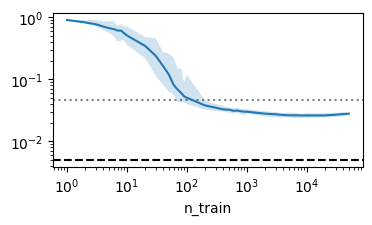

In [8]:
def plot_wandb_df(
    df: pd.DataFrame,
    query: str,
    target: str = "err",
    ci: float = 0.99,
    **kwargs,
):
    gb = df.query(
        "&".join(
            (
                "dataset_id == 'cifar10'",
                "cls_start == 0",
                "cls_end == 10",
                "(c == 100 | k == 1)",
                # "embedder_id == 'openai/ViT-L/14'",
                # "probe == 'linear'",
                # "per_class == False",
                query,
            )
        )
    ).groupby(["n_train"])

    ax = gb[target].median().plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2),
        gb[target].quantile(0.5 + ci / 2),
        alpha=0.2,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    return ax


def plot_strong_baselines():
    # Human accuracy
    # Karpathy gives 94% (http://karpathy.github.io/2011/04/27/manually-classifying-cifar10/)
    # https://arxiv.org/abs/1811.07270 gives 93.91 \pm 1.52%
    # We'll give an upper bound of 93.91 + 1.52 = 95.43%
    plt.axhline(
        1 - 0.9543,
        color="k",
        linestyle=":",
        label="Human performance (95.43%)",
        zorder=-10,
        alpha=0.5,
    )

    # https://paperswithcode.com/sota/image-classification-on-cifar-10
    plt.axhline(
        1 - 0.995,
        color="k",
        linestyle="--",
        label="SOTA (paperswithcode.com 2022-12-30)",
        zorder=-10,
    )


plt.figure(figsize=(4, 2))
embedder_id = "openai/ViT-L/14"
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
)
plot_strong_baselines()
plt.xscale("log")
plt.yscale("log")

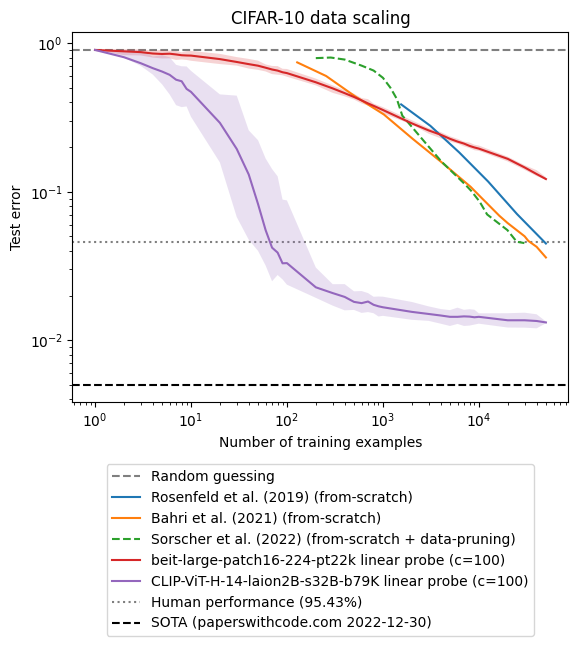

In [9]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)
# plt.plot(
#     df_prune_transfer.n_train,
#     df_prune_transfer.err,
#     label="Sorscher et al. (2022) (data pruning + whole-model-finetuning)",
# )
plt.plot(
    df_prune_scratch.n_train,
    df_prune_scratch.err,
    label="Sorscher et al. (2022) (from-scratch + data-pruning)",
    linestyle="--",
)

for embedder_id in (
    "hf/microsoft/beit-large-patch16-224-pt22k",
    # "openai/ViT-L/14",
    "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/microsoft/beit-large-patch16-224",
):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id.split('/')[-1]} linear probe (c=100)",
    )
    # plot_wandb_df(
    #     df,
    #     query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
    #     label=f"{embedder_id} knn probe (k=1)",
    # )
    # plot_err(
    #     cdf.query(
    #         "probe == 'linear' & c == 0.01 & embedder_id == @embedder_id"
    #     ),
    #     label=f"{embedder_id} linear probe (balanced classes)",
    #     per_class=True,
    #     linestyle="--",
    # )

# plot_err(
#     cdf.query("probe == 'knn' & k == 3"),
#     label=f"{embedder_id} knn probe",
# )
# plot_err(
#     cdf.query("probe == 'knn' & k == 3"),
#     label=f"{embedder_id} linear probe (balanced classes)",
#     per_class=True,
#     linestyle="--",
# )

plot_strong_baselines()
plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

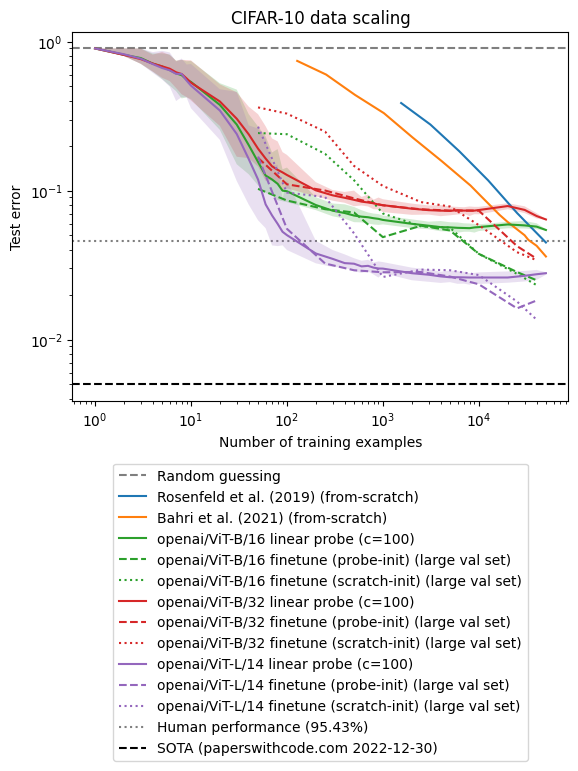

In [10]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

for embedder_id in (
    # "hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K",
    # "hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/laion/CLIP-ViT-L-14-laion2B-s32B-b82K",
    "openai/ViT-B/16",
    "openai/ViT-B/32",
    "openai/ViT-L/14",
    # "openai/ViT-L/14@336px",
):
    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )
    prev_color = ax.lines[-1].get_color()

    cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        linestyle="--",
        color=prev_color,
        label=f"{embedder_id} finetune (probe-init) (large val set)",
    )

    cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "~init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        linestyle=":",
        color=prev_color,
        label=f"{embedder_id} finetune (scratch-init) (large val set)",
    )
    # plt.plot(
    #     cdf.n_train - cdf.n_val_override,
    #     cdf.val_err,
    #     linestyle=":",
    #     color=prev_color,
    #     label=f"{embedder_id} finetune (val) (large val set)",
    # )
    # plt.plot(
    #     cdf.n_train,
    #     cdf.train_err,
    #     linestyle="-.",
    #     color=prev_color,
    #     label=f"{embedder_id} finetune (train)",
    # )

# cdf = df_finetune_old.query(f"weight_decay == 0")
# plt.plot(
#     cdf.n_train,
#     cdf.test_err,
#     label=f"openai/ViT-L/14 OLD finetune",
#     linestyle="--",
#     zorder=-10,
# )

plot_strong_baselines()
plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
# plt.yscale("symlog", linthresh=9e-3)
# plt.ylim(-1e-3, 1.1)
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

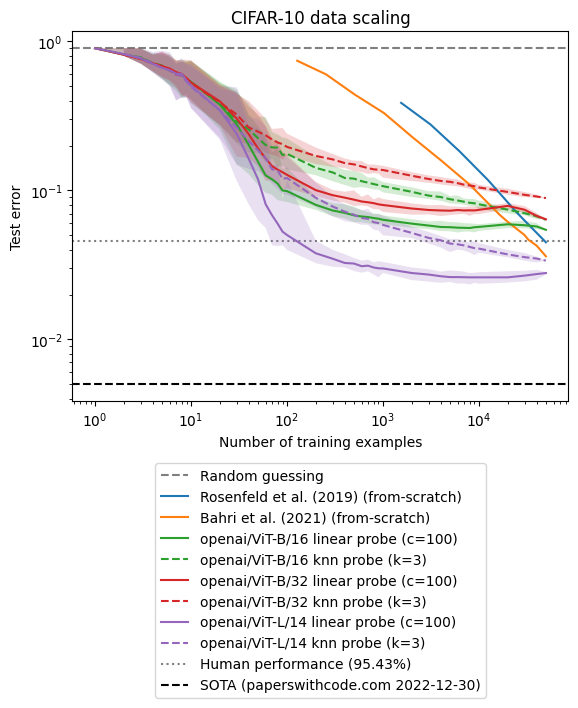

In [11]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

for embedder_id in (
    # "hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K",
    # "hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/laion/CLIP-ViT-L-14-laion2B-s32B-b82K",
    "openai/ViT-B/16",
    "openai/ViT-B/32",
    "openai/ViT-L/14",
    # "openai/ViT-L/14@336px",
):
    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )
    prev_color = ax.lines[-1].get_color()

    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
        label=f"{embedder_id} knn probe (k=3)",
        linestyle="--",
        color=prev_color,
    )
    prev_color = ax.lines[-1].get_color()

plot_strong_baselines()
plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
# plt.yscale("symlog", linthresh=9e-3)
# plt.ylim(-1e-3, 1.1)
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

### Study different types of probes

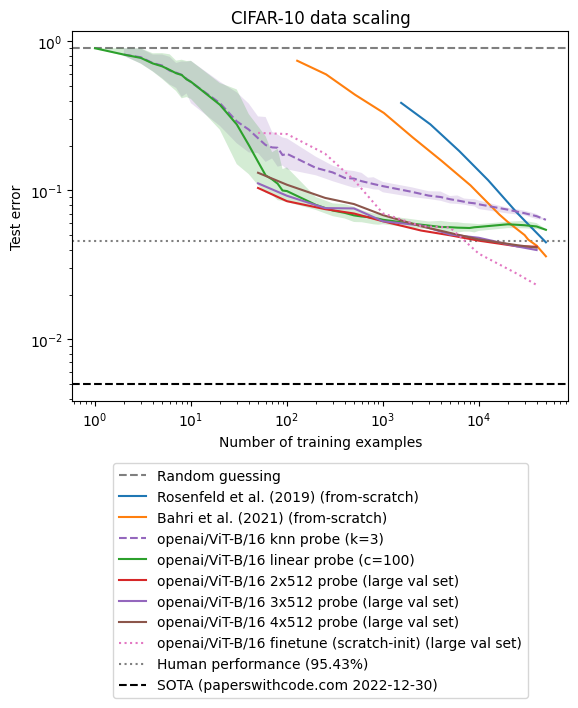

In [12]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_rosenfeld.n_train,
    df_rosenfeld.err,
    label="Rosenfeld et al. (2019) (from-scratch) ",
)
plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

embedder_id = "openai/ViT-B/16"

plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
    label=f"{embedder_id} knn probe (k=3)",
    linestyle="--",
    color=prev_color,
)
ax = plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
    label=f"{embedder_id} linear probe (c=100)",
)
prev_color = ax.lines[-1].get_color()

for n_layers in [2, 3, 4]:
    for hidden_dim in [512]: #[512, 1024, 2048]:
        cdf = df_probe_scaling.query(
            "&".join(
                (
                    f"embedder_cfg_id == @embedder_id",
                    f"fc_probe_cfg_n_layers == @n_layers",
                    f"fc_probe_cfg_hidden_dim == @hidden_dim",
                )
            )
        ).sort_values("n_train").reset_index(drop=True)
        plt.plot(
            cdf.n_train - cdf.n_val_override,
            cdf.test_err,
            label=f"{embedder_id} {n_layers}x{hidden_dim} probe (large val set)",
        )

cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "~init_with_trained_linear_probe",
            )
        )
).sort_values("n_train")
plt.plot(
    cdf.n_train - cdf.n_val_override,
    cdf.test_err,
    linestyle=":",
    label=f"{embedder_id} finetune (scratch-init) (large val set)",
)

plot_strong_baselines()
plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
# plt.yscale("symlog", linthresh=9e-3)
# plt.ylim(-1e-3, 1.1)
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()


### Freeze plots

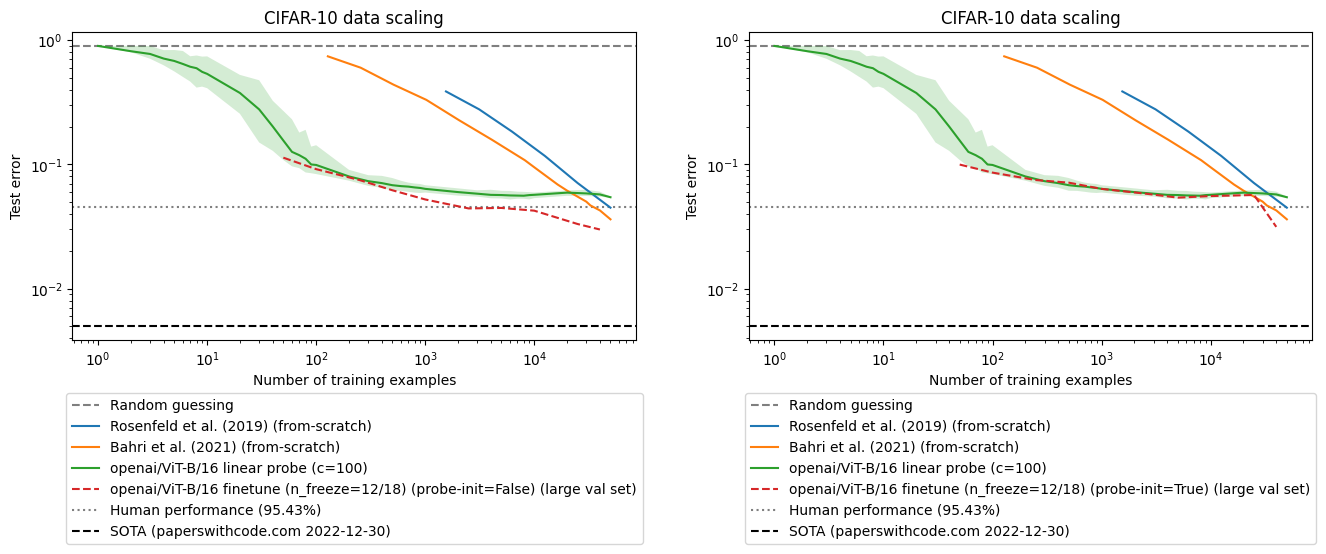

In [13]:
plt.figure(figsize=(16, 4))
for i, init_with_trained in enumerate((False, True)):
    plt.subplot(1, 2, i + 1)

    plt.axhline(
        0.9,
        color="k",
        linestyle="--",
        label="Random guessing",
        zorder=-10,
        alpha=0.5,
    )

    plt.plot(
        df_rosenfeld.n_train,
        df_rosenfeld.err,
        label="Rosenfeld et al. (2019) (from-scratch) ",
    )
    plt.plot(
        df_bahri.n_train,
        df_bahri.err,
        label="Bahri et al. (2021) (from-scratch)",
    )

    embedder_id = "openai/ViT-B/16"

    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )

    for n_freeze in [12]:#[0, 5, 10, 12, 15]:
        cdf = df_finetune_freeze.query(
            "&".join(
                (
                    "embedder_cfg_id == @embedder_id",
                    "init_with_trained_linear_probe"
                    if init_with_trained
                    else "~init_with_trained_linear_probe",
                    "n_layers_to_freeze == @n_freeze",
                )
            )
        ).sort_values("n_train")
        plt.plot(
            cdf.n_train - cdf.n_val_override,
            cdf.test_err,
            linestyle="--",
            label=f"{embedder_id} finetune ({n_freeze=}/18) (probe-init={init_with_trained}) (large val set)",
        )

    # cdf = df_finetune.query(
    #     "&".join(
    #         (
    #             "embedder_cfg_id == @embedder_id",
    #             "~init_with_trained_linear_probe",
    #         )
    #     )
    # ).sort_values("n_train")
    # plt.plot(
    #     cdf.n_train - cdf.n_val_override,
    #     cdf.test_err,
    #     linestyle=":",
    #     color=prev_color,
    #     label=f"{embedder_id} finetune (scratch-init) (large val set)",
    # )

    plot_strong_baselines()
    plt.title(f"CIFAR-10 data scaling")

    plt.xscale("log")
    plt.yscale("log")
    # plt.yscale("symlog", linthresh=9e-3)
    # plt.ylim(-1e-3, 1.1)
    plt.xlabel("Number of training examples")
    plt.ylabel(f"Test error")

    # Plot legend underneath plot
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=1,
    )

### More plots

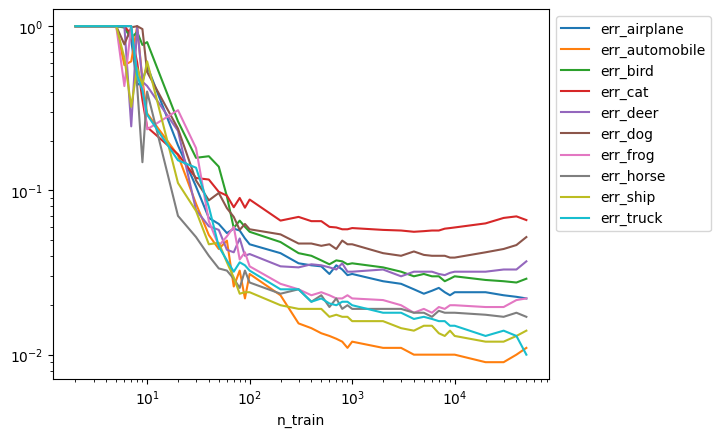

In [9]:
dataset_cfg = cifar10.CIFAR10()
embedder_id = "openai/ViT-L/14"
for i in range(10):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        target=f"err_{i}",
        label=f"err_{dataset_cfg.class_names[i]}",
        ci=0
    )

plt.xscale("log")
plt.yscale("log")

# Legend on outside top right
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
);

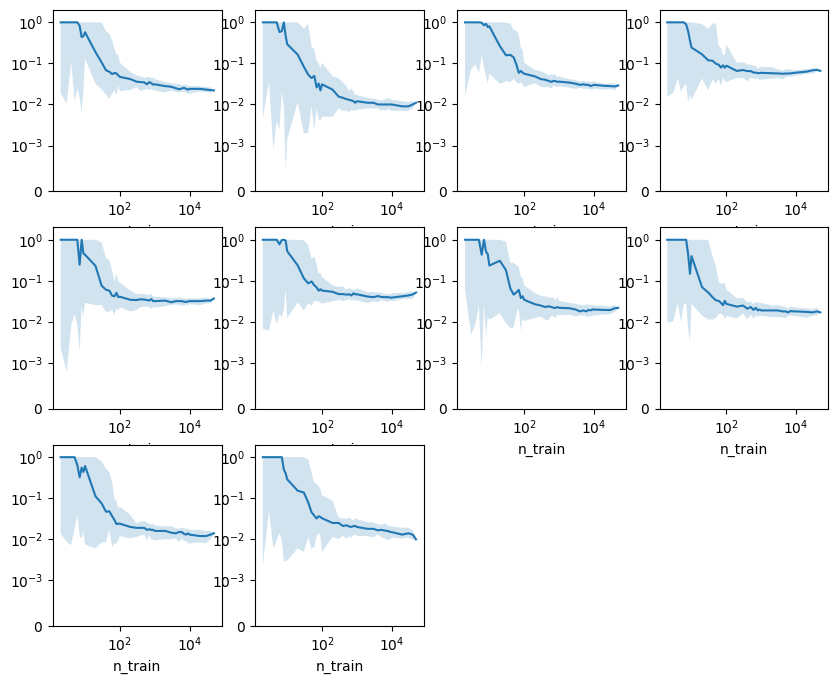

In [14]:
plt.figure(figsize=(10, 8))

# "openai/ViT-L/14"
# "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
# "hf/microsoft/beit-large-patch16-224"
embedder_id = "openai/ViT-L/14"
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        target=f"err_{i}",
        ci=0.9
    )
    plt.xscale("log")
    plt.yscale("symlog", linthresh=1e-3)
    plt.ylim(0, 2)